<a href="https://colab.research.google.com/github/packetech/baracuda/blob/master/RS_Amazon_Product_Recommendation_Project_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement - 

Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

Source -   Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Electronics dataset.Please do the analysis based on steps (1 to 8) as given below -  
Steps - 
1.   Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics)
2.   Take a subset of the dataset to make it less sparse/ denser. (For example, keep the users only who has given 50 or more number of ratings.)
3.   Split the data randomly into train and test dataset. (For example, split it in 70/30 ratio)
4.   Build Popularity Recommender model. 
5.   Build Collaborative Filtering model. 
6.   Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)  
7.   Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. 
8.   Summarize your insights.

Reference links - https://www.computer.org/csdl/mags/ic/2017/03/mic2017030012.htmlProprietary content. ©Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited

Proprietary content. ©Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

© 2020 All rights reserved

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
#Import required libraries
import numpy as np
import pandas as pd
import math
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

##1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)

In [42]:
# Change to working directory
os.chdir('/content/drive/My Drive/AIML/Recommendation-System')
!pwd

/content/drive/My Drive/AIML/Recommendation-System


In [43]:
# Read data and add headers
df_RecoSys = pd.read_csv('ratings_Electronics.csv', names=["userId", "productId", "ratings", "timestamp"])
df_RecoSys.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [44]:
# discard the timestamp column as advised
df_RecoSys = df_RecoSys.drop(labels="timestamp", axis = 1)
df_RecoSys.head()                

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [45]:
# Check the number of rows and columns
rows, columns = df_RecoSys.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  7824482
No of columns:  3


In [46]:
#Check Data types
df_RecoSys.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [47]:
# Check for missing values; shows there are none
print('Number of missing values across columns-\n', df_RecoSys.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
ratings      0
dtype: int64


In [48]:
# Summary of the statistics of 'ratings' variable (shows that the distribution is skewed[i.e. long tailed to the left])
df_RecoSys['ratings'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [49]:
# Minimum and maximum ratings
print('The minimum rating is: %d' %(df_RecoSys['ratings'].min()))
print('The maximum rating is: %d' %(df_RecoSys['ratings'].max()))

The minimum rating is: 1
The maximum rating is: 5


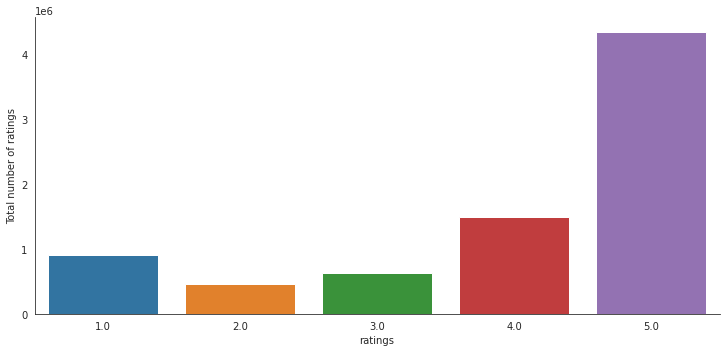

In [50]:
# Checking the actual distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df_RecoSys, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

Observation:
The histogram above confirms our abnormal distribution

In [51]:
# Number of unique userid and productid in the initial dataset
print('Number of unique USERS in initial data = ', df_RecoSys['userId'].nunique())
print('Number of unique ITEMS in initial data = ', df_RecoSys['productId'].nunique())

Number of unique USERS in initial data =  4201696
Number of unique ITEMS in initial data =  476002


##2. Take a subset of the dataset to make it less sparse/ denser. (For example, keep the users only who has given 50 or more number of ratings.)

In [13]:
# Top 10 users based on rating
most_rated = df_RecoSys.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [256]:
# Carrying out the selection based on users who have made 50 or more ratings
counts = df_RecoSys['userId'].value_counts()
df_RecoSys_final = df_RecoSys[df_RecoSys['userId'].isin(counts[counts >= 250].index)]
print(df_RecoSys_final)

                 userId   productId  ratings
2162      A5JLAU2ARJ0BO  1400532655      1.0
3383     A3PD8JD9L4WEII  1400699169      5.0
5195     A36K2N527TXXJN  9800359788      5.0
5932       ADLVFFE4VBT8  9981719005      3.0
7748      A680RUE1FDO8B  B000001OMI      5.0
...                 ...         ...      ...
7824163  A3AYSYSLHU26U9  B00L3YHF6O      5.0
7824198   AWPODHOB4GFWL  B00L3YHF6O      5.0
7824212  A2XRMQA6PJ5ZJ8  B00L3YHF6O      5.0
7824425  A25C2M3QF9G7OQ  B00LGQ6HL8      5.0
7824436  A3AYSYSLHU26U9  B00LI4ZZO8      4.0

[7484 rows x 3 columns]


In [257]:
# Number of unique userid and productid in the final dataset
print('Number of users that have rated 100 or more items = ', len(df_RecoSys_final))
print('Number of unique USERS in final data = ', df_RecoSys_final['userId'].nunique())
print('Number of unique ITEMS in final data = ', df_RecoSys_final['productId'].nunique())

Number of users that have rated 100 or more items =  7484
Number of unique USERS in final data =  23
Number of unique ITEMS in final data =  5841


In [258]:
# Calculating the density of the rating matrix
final_RatingsMatrix = df_RecoSys_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
print('Shape of final_RatingsMatrix: ', final_RatingsMatrix.shape)

given_num_of_ratings = np.count_nonzero(final_RatingsMatrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_RatingsMatrix.shape[0] * final_RatingsMatrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_RatingsMatrix:  (23, 5841)
given_num_of_ratings =  7484
possible_num_of_ratings =  134343
density: 5.57%


In [259]:
final_RatingsMatrix.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZM7T2Q,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0
A22CW0ZHY3NJH8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##3. Spliting data randomly into train and test dataset (in the ratio 70/30)

In [260]:
# Train and test final data split in ratio 70/30
train, test = train_test_split(df_RecoSys_final, test_size = 0.3, random_state=7)
train.head()

,userId,productId,ratings
7265126,A3PD8JD9L4WEII,B00CHT6CRC,4.0
4024419,A3OXHLG6DIBRW8,B004CLYEDC,5.0
687793,A3OXHLG6DIBRW8,B0009VT9OS,5.0
1618643,A3OXHLG6DIBRW8,B0012UCYVU,5.0
6474573,ADLVFFE4VBT8,B0094C0DYI,5.0


In [261]:
train.shape

(5238, 3)

In [262]:
test.shape

(2246, 3)

##4. Building Popularity Recommender model

In [263]:
#Count of userid for each unique product as recommendation score 
train_grouped = train.groupby('productId').agg({'userId': 'count'}).reset_index()
train_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_grouped.head()

,productId,score
0,1400699169,1
1,9800359788,1
2,9981719005,1
3,B00000J05A,1
4,B00000J1QS,1


In [264]:
#Sorting the products on recommendation score 
train_sort = train_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generating a recommendation rank based upon score 
train_sort['rank'] = train_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_sort.head(5) 
popularity_recommendations 

,productId,score,rank
2874,B0053R0WWG,9,1.0
1068,B000JMJWV2,8,2.0
3279,B007OY5V68,8,3.0
3915,B00DTZYHX4,8,4.0
3000,B005IMFX2K,7,5.0


In [265]:
# Make predictions by Using popularity based recommender model
def recommend(userId):     
    user_recommendations = popularity_recommendations 
          
    #Add userid column for which the recommendations are being generated 
    user_recommendations['userId'] = userId 
      
    #Bring userid column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [266]:
find_recom = [10,131,73]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 10

      userId   productId  score  rank
2874      10  B0053R0WWG      9   1.0
1068      10  B000JMJWV2      8   2.0
3279      10  B007OY5V68      8   3.0
3915      10  B00DTZYHX4      8   4.0
3000      10  B005IMFX2K      7   5.0


Here is the recommendation for the userId: 131

      userId   productId  score  rank
2874     131  B0053R0WWG      9   1.0
1068     131  B000JMJWV2      8   2.0
3279     131  B007OY5V68      8   3.0
3915     131  B00DTZYHX4      8   4.0
3000     131  B005IMFX2K      7   5.0


Here is the recommendation for the userId: 73

      userId   productId  score  rank
2874      73  B0053R0WWG      9   1.0
1068      73  B000JMJWV2      8   2.0
3279      73  B007OY5V68      8   3.0
3915      73  B00DTZYHX4      8   4.0
3000      73  B005IMFX2K      7   5.0




**Observation:** 

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity

##5. Building Collaborative Filtering model

This is a Model-based Collaborative Filtering

In [267]:

df_RecoSys_CF = df_RecoSys_final
df_RecoSys_CF.head()

,userId,productId,ratings
2162,A5JLAU2ARJ0BO,1400532655,1.0
3383,A3PD8JD9L4WEII,1400699169,5.0
5195,A36K2N527TXXJN,9800359788,5.0
5932,ADLVFFE4VBT8,9981719005,3.0
7748,A680RUE1FDO8B,B000001OMI,5.0


In [268]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_RecoSys_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.shape

(23, 5841)

In [269]:
pivot_df.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZM7T2Q,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0
A22CW0ZHY3NJH8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8,user_index
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,2
A22CW0ZHY3NJH8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,3
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [271]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZM7T2Q,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Singular Value Decomposition (SVD), is the best to apply on a large sparse matrix like ours

In [274]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 20)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [275]:
# Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZM7T2Q,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8
0,0.000541,0.497435,0.146975,0.099719,-0.004952,0.024195,0.227136,0.040325,-0.028608,0.024195,-0.022887,-0.017165,0.227136,0.029339,0.036674,-0.022887,-0.060991,-0.028608,0.416292,-0.022887,0.024195,-0.100046,0.024195,0.255442,0.040325,-0.028608,-0.028608,-0.546336,0.014670,-0.028608,0.132959,-0.017165,0.489058,0.002704,-0.028608,0.022004,-0.028608,-0.022887,0.032260,-0.022887,...,0.117580,0.301859,0.362850,0.495085,0.017533,0.496371,0.081698,0.081698,0.081698,0.371996,-0.100046,0.852426,0.117580,-0.100046,0.509825,-0.100046,0.362850,0.362850,-0.100046,0.466976,0.283921,0.349396,-0.100046,0.917175,0.395038,0.102122,-0.100046,0.461032,0.362850,0.102122,-0.533858,0.464972,-0.100046,0.105207,0.538868,-0.060991,0.061273,0.816699,0.371996,0.349396
1,-0.004325,0.110819,0.019315,0.144014,0.130967,0.037825,0.220342,0.063042,0.024091,0.037825,0.019273,0.014455,0.220342,0.087358,0.109197,0.019273,-0.085592,0.024091,-0.112385,0.019273,0.037825,-0.033976,0.037825,0.022145,0.063042,0.024091,0.024091,0.354953,0.043679,0.024091,0.192019,0.014455,0.456594,-0.021627,0.024091,0.065518,0.024091,0.019273,0.050433,0.019273,...,0.015452,-0.220779,-0.135187,0.013840,-0.018523,0.150016,0.070912,0.070912,0.070912,-0.005914,-0.033976,-0.125649,0.015452,-0.033976,-0.115872,-0.033976,-0.135187,-0.135187,-0.033976,0.146153,0.275427,0.130701,-0.033976,0.043641,-0.020135,0.088640,-0.033976,-0.184346,-0.135187,0.088640,0.305645,-0.046547,-0.033976,0.154432,0.252017,-0.085592,0.053184,0.637420,-0.005914,0.130701
2,-0.000598,-0.157390,-0.067723,-0.014180,-0.000487,0.000628,-0.126004,0.001046,0.020120,0.000628,0.016096,0.012072,-0.126004,-0.004782,-0.005977,0.016096,0.178182,0.020120,0.038619,0.016096,0.000628,0.046526,0.000628,0.081698,0.001046,0.020120,0.020120,0.176823,-0.002391,0.020120,-0.018907,0.012072,-0.372521,-0.002990,0.020120,-0.003586,0.020120,0.016096,0.000837,0.016096,...,-0.054178,0.145038,-0.033144,-0.030565,-0.007653,0.591217,3.847374,3.847374,3.847374,-0.113688,0.046526,-0.201010,-0.054178,0.046526,-0.100867,0.046526,-0.033144,-0.033144,0.046526,0.604761,-0.157506,0.658940,0.046526,0.736352,0.015961,4.809218,0.046526,0.041678,-0.033144,4.809218,0.156285,4.776073,0.046526,0.154548,5.632892,0.178182,2.885531,0.635013,-0.113688,0.658940
3,0.000555,0.143944,0.062422,0.012623,0.000554,-0.000751,0.116571,-0.001252,-0.018643,-0.000751,-0.014914,-0.011186,0.116571,0.004306,0.005383,-0.014914,4.833330,-0.018643,-0.039356,-0.014914,-0.000751,-0.042901,-0.000751,-0.048793,-0.001252,-0.018643,-0.018643,-0.161588,0.002153,-0.018643,0.016831,-0.011186,0.345897,0.002774,-0.018643,0.003230,-0.018643,-0.014914,-0.001001,-0.014914,...,0.049938,4.861653,0.028323,0.024991,0.007037,-0.558007,0.142545,0.142545,0.142545,0.103841,-0.042901,0.182102,0.049938,-0.042901,0.090745,-0.042901,0.028323,0.028323,-0.042901,-0.570491,0.145714,-0.620429,-0.042901,-0.697276,-0.017909,0.178182,-0.042901,3.957409,0.028323,0.178182,-0.142444,0.206504,-0.042901,4.854369,-0.597355,4.833330,0.106909,-0.601229,0.103841,-0.620429
4,0.000095,0.017888,0.007640,0.000902,-0.000861,-0.000235,0.012782,-0.000391,4.99

##6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [276]:
# Evaluation of Model-based Collaborative Filtering (SVD)

# Actual ratings given by the users
final_RatingsMatrix.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZM7T2Q,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0
A22CW0ZHY3NJH8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
# Average ACTUAL rating for each item
final_RatingsMatrix.mean().head()

productId
1400532655    0.043478
1400699169    0.217391
9800359788    0.217391
9981719005    0.130435
B000001OMI    0.217391
dtype: float64

In [278]:
# Predicted ratings 
preds_df.head()

productId,1400532655,1400699169,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J1US,B00000J4CY,B00000J570,B00000JFJA,B00000JGNB,B00000JHX1,B00000JLSJ,B00000JSGF,B00000K135,B00000K4KH,B00001OPJZ,B00001OPK8,B00001P4X5,B00001P4XA,B00001P4ZH,B00001RMDL,B00001W0DI,B00001YVG4,B000021YUO,B000023VUL,B000026D8E,B000028F42,B00002NDRF,B00002SWHH,B00003006E,B00003006R,B0000304ZO,B000031WDA,B000038AB2,B00003CWCI,B00003CWDH,B00003CWE8,...,B00JZM7T2Q,B00JZXDG7M,B00K2L3G5I,B00K6B7KJM,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KD3EW4O,B00KFBX9XY,B00KGCALLU,B00KGE4VS2,B00KGQC4QQ,B00KH8PUDW,B00KHA2DQM,B00KHA5G6G,B00KHF4T46,B00KIMX4EY,B00KINSDK8,B00KJJW36G,B00KKOYZWU,B00KLGSQJ0,B00KMRGB7C,B00KNEBRT6,B00KVLY8E2,B00KVNY2KA,B00KWL62QI,B00KWMNDDM,B00KXMN08E,B00KYMCJF8,B00L0YFJHY,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8,B00LI4ZZO8
0,0.000541,0.497435,0.146975,0.099719,-0.004952,0.024195,0.227136,0.040325,-0.028608,0.024195,-0.022887,-0.017165,0.227136,0.029339,0.036674,-0.022887,-0.060991,-0.028608,0.416292,-0.022887,0.024195,-0.100046,0.024195,0.255442,0.040325,-0.028608,-0.028608,-0.546336,0.014670,-0.028608,0.132959,-0.017165,0.489058,0.002704,-0.028608,0.022004,-0.028608,-0.022887,0.032260,-0.022887,...,0.117580,0.301859,0.362850,0.495085,0.017533,0.496371,0.081698,0.081698,0.081698,0.371996,-0.100046,0.852426,0.117580,-0.100046,0.509825,-0.100046,0.362850,0.362850,-0.100046,0.466976,0.283921,0.349396,-0.100046,0.917175,0.395038,0.102122,-0.100046,0.461032,0.362850,0.102122,-0.533858,0.464972,-0.100046,0.105207,0.538868,-0.060991,0.061273,0.816699,0.371996,0.349396
1,-0.004325,0.110819,0.019315,0.144014,0.130967,0.037825,0.220342,0.063042,0.024091,0.037825,0.019273,0.014455,0.220342,0.087358,0.109197,0.019273,-0.085592,0.024091,-0.112385,0.019273,0.037825,-0.033976,0.037825,0.022145,0.063042,0.024091,0.024091,0.354953,0.043679,0.024091,0.192019,0.014455,0.456594,-0.021627,0.024091,0.065518,0.024091,0.019273,0.050433,0.019273,...,0.015452,-0.220779,-0.135187,0.013840,-0.018523,0.150016,0.070912,0.070912,0.070912,-0.005914,-0.033976,-0.125649,0.015452,-0.033976,-0.115872,-0.033976,-0.135187,-0.135187,-0.033976,0.146153,0.275427,0.130701,-0.033976,0.043641,-0.020135,0.088640,-0.033976,-0.184346,-0.135187,0.088640,0.305645,-0.046547,-0.033976,0.154432,0.252017,-0.085592,0.053184,0.637420,-0.005914,0.130701
2,-0.000598,-0.157390,-0.067723,-0.014180,-0.000487,0.000628,-0.126004,0.001046,0.020120,0.000628,0.016096,0.012072,-0.126004,-0.004782,-0.005977,0.016096,0.178182,0.020120,0.038619,0.016096,0.000628,0.046526,0.000628,0.081698,0.001046,0.020120,0.020120,0.176823,-0.002391,0.020120,-0.018907,0.012072,-0.372521,-0.002990,0.020120,-0.003586,0.020120,0.016096,0.000837,0.016096,...,-0.054178,0.145038,-0.033144,-0.030565,-0.007653,0.591217,3.847374,3.847374,3.847374,-0.113688,0.046526,-0.201010,-0.054178,0.046526,-0.100867,0.046526,-0.033144,-0.033144,0.046526,0.604761,-0.157506,0.658940,0.046526,0.736352,0.015961,4.809218,0.046526,0.041678,-0.033144,4.809218,0.156285,4.776073,0.046526,0.154548,5.632892,0.178182,2.885531,0.635013,-0.113688,0.658940
3,0.000555,0.143944,0.062422,0.012623,0.000554,-0.000751,0.116571,-0.001252,-0.018643,-0.000751,-0.014914,-0.011186,0.116571,0.004306,0.005383,-0.014914,4.833330,-0.018643,-0.039356,-0.014914,-0.000751,-0.042901,-0.000751,-0.048793,-0.001252,-0.018643,-0.018643,-0.161588,0.002153,-0.018643,0.016831,-0.011186,0.345897,0.002774,-0.018643,0.003230,-0.018643,-0.014914,-0.001001,-0.014914,...,0.049938,4.861653,0.028323,0.024991,0.007037,-0.558007,0.142545,0.142545,0.142545,0.103841,-0.042901,0.182102,0.049938,-0.042901,0.090745,-0.042901,0.028323,0.028323,-0.042901,-0.570491,0.145714,-0.620429,-0.042901,-0.697276,-0.017909,0.178182,-0.042901,3.957409,0.028323,0.178182,-0.142444,0.206504,-0.042901,4.854369,-0.597355,4.833330,0.106909,-0.601229,0.103841,-0.620429
4,0.000095,0.017888,0.007640,0.000902,-0.000861,-0.000235,0.012782,-0.000391,4.99

In [279]:
rmse_df = pd.concat([final_RatingsMatrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)


(5841, 2)


In [280]:
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.043478,0.043398,0
1400699169,0.217391,0.237891,1
9800359788,0.217391,0.224283,2
9981719005,0.130435,0.137040,3
B000001OMI,0.217391,0.221094,4


In [281]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.02809 



##7.  Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products

In [282]:
# Recommend the items with the highest predicted ratings

def recommend_items(userId, pivot_df, preds_df, num_recommendations):
      
    user_idx = userId-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 2]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userId))
    print(temp.head(num_recommendations))

In [283]:
# Enter 'userId' and 'num_recommendations' for the user #
userId = 20
num_recommendations = 5
recommend_items(userId, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B00DR0PDNE                  2.0          2.030097
B00005138B                  2.0          1.999514
B00005ML56                  2.0          1.999514
B002SNI1VM                  2.0          1.999514
B001IZYV2E                  2.0          1.999514


##8. Summary of insights

For Model-based Collaborative Filtering; the recommendations are based on the past activity of the user and it is not dependent on any additional information. Hence the reason it is a personalized recommendation system. 

But Popularity-based recommender system is not personalized and the recommendations are based on frequecy counts, which may not be ok for the user.
Check out the users (10,131,73), in the above, Popularity-based model has recommended the same set of 5 items for all of them. 
But Collaborative Filtering Model recommended quite differently for each users based on their past activities on ratings

There had to be a trade off in selecting the best records. In this case we considered users who have made ratings of 250 or more items, so that we will have more sparse or denser dataset(i.e. we will have lesser items that have not been rated) with that we have our user_ratings and User_predictions closely matching one another.
